In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)

In [13]:
trader_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")


In [14]:
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], errors='coerce')
trader_df['date'] = trader_df['Timestamp IST'].dt.date
print(trader_df.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-02-12 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-02-12 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-02-12 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-02-12 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-02-12 22:50:00     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0

In [15]:
os.makedirs("csv_files", exist_ok=True)
merged_df.to_csv("csv_files/merged_trader_sentiment.csv", index=False)

print("merged_trader_sentiment.csv file created and saved in /csv_files/")


merged_trader_sentiment.csv file created and saved in /csv_files/


In [16]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date
sentiment_df = sentiment_df[['date', 'value', 'classification']]
print(sentiment_df.head())

         date  value classification
0  2018-02-01     30           Fear
1  2018-02-02     15   Extreme Fear
2  2018-02-03     40           Fear
3  2018-02-04     24   Extreme Fear
4  2018-02-05     11   Extreme Fear


In [17]:
daily_trader = trader_df.groupby('date').agg({
    'Size USD': 'sum',
    'Size Tokens': 'sum',
    'Closed PnL': 'sum',
    'Execution Price': 'mean',
    'Fee': 'sum',
    'Side': lambda x: (x=='BUY').sum() / len(x)
}).reset_index()

daily_trader.rename(columns={
    'Size USD': 'total_usd_volume',
    'Size Tokens': 'total_token_volume',
    'Closed PnL': 'net_pnl',
    'Execution Price': 'avg_exec_price',
    'Fee': 'total_fees',
    'Side': 'buy_ratio'
}, inplace=True)

print(daily_trader.head())

         date  total_usd_volume  total_token_volume      net_pnl  \
0  2023-01-05            477.00        2.513000e-01     0.000000   
1  2023-05-12          50005.83        1.180901e+01     0.000000   
2  2024-01-01         264239.53        4.178787e+03  -129.531460   
3  2024-01-02           2008.18        4.498600e+04     0.000000   
4  2024-01-03         472974.70        2.598468e+07  8244.241409   

   avg_exec_price  total_fees  buy_ratio  
0     1898.133333    0.000000   1.000000  
1    11038.300000   12.501455   0.777778  
2    10373.330667   66.059867   0.555556  
3        0.076126    0.502044   1.000000  
4        2.725657   -0.546854   0.270073  


In [18]:
merged_df = pd.merge(daily_trader, sentiment_df, on='date', how='inner')
print(merged_df.head())

         date  total_usd_volume  total_token_volume      net_pnl  \
0  2023-01-05            477.00        2.513000e-01     0.000000   
1  2023-05-12          50005.83        1.180901e+01     0.000000   
2  2024-01-01         264239.53        4.178787e+03  -129.531460   
3  2024-01-02           2008.18        4.498600e+04     0.000000   
4  2024-01-03         472974.70        2.598468e+07  8244.241409   

   avg_exec_price  total_fees  buy_ratio  value classification  
0     1898.133333    0.000000   1.000000     29           Fear  
1    11038.300000   12.501455   0.777778     49        Neutral  
2    10373.330667   66.059867   0.555556     65          Greed  
3        0.076126    0.502044   1.000000     71          Greed  
4        2.725657   -0.546854   0.270073     70          Greed  


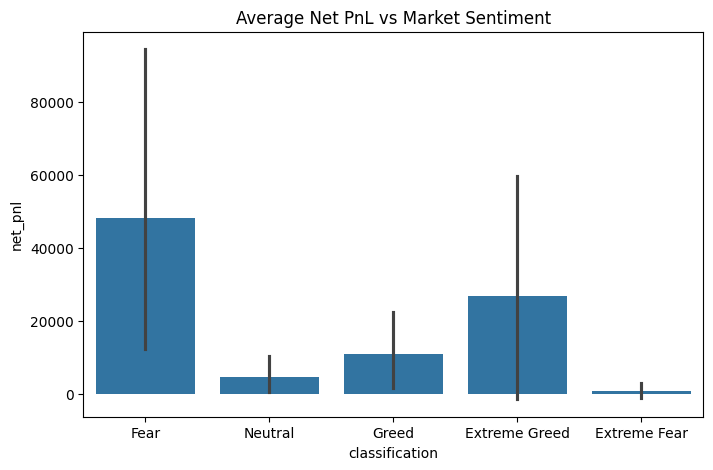

In [19]:
# Avg PnL vs Sentiment Class
plt.figure(figsize=(8,5))
sns.barplot(data=merged_df, x='classification', y='net_pnl', estimator=np.mean)
plt.title("Average Net PnL vs Market Sentiment")
plt.show()


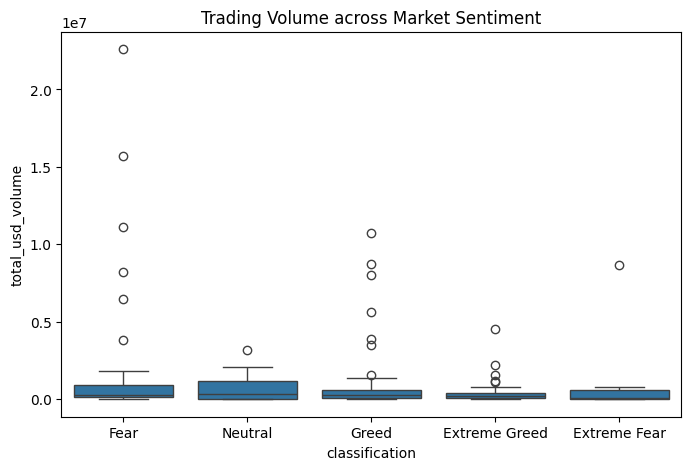

In [20]:
# Volume vs Fear/Greed
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='classification', y='total_usd_volume')
plt.title("Trading Volume across Market Sentiment")
plt.show()



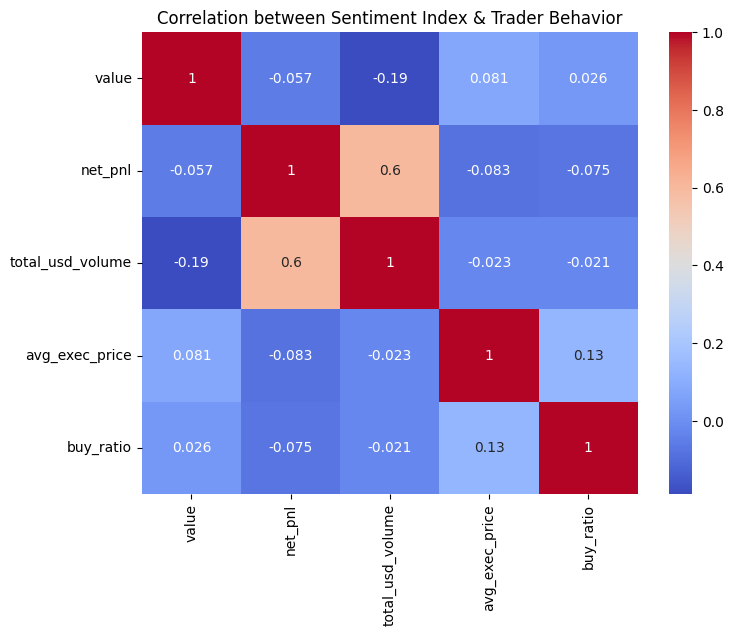

In [21]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[['value','net_pnl','total_usd_volume','avg_exec_price','buy_ratio']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Sentiment Index & Trader Behavior")
plt.show()


<Figure size 1200x600 with 0 Axes>

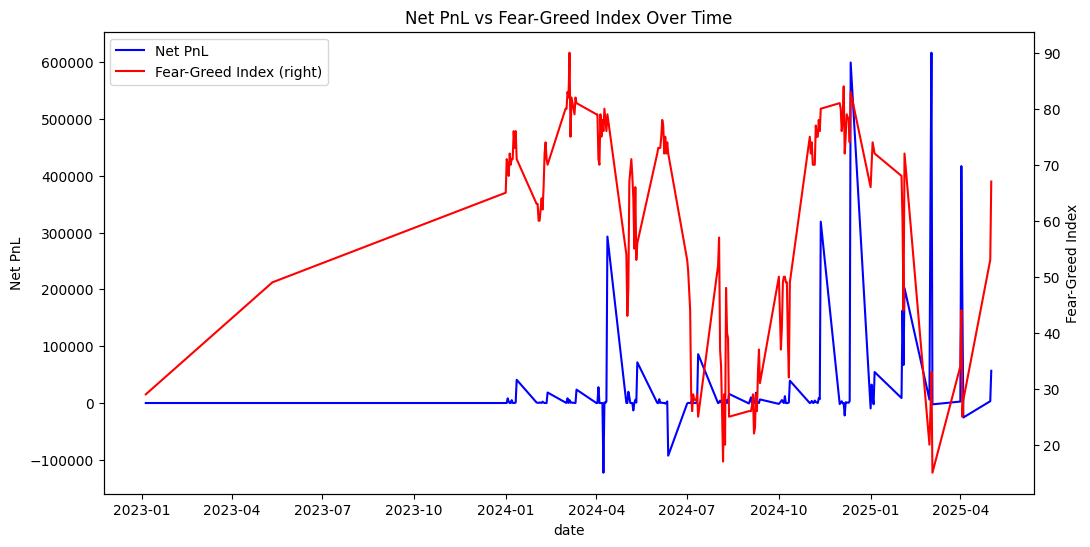

In [22]:
# Time series comparison
plt.figure(figsize=(12,6))
ax1 = merged_df.plot(x='date', y='net_pnl', label='Net PnL', color='blue', figsize=(12,6))
ax2 = merged_df.plot(x='date', y='value', secondary_y=True, ax=ax1, color='red', label='Fear-Greed Index')
ax1.set_ylabel("Net PnL")
ax2.set_ylabel("Fear-Greed Index")
plt.title("Net PnL vs Fear-Greed Index Over Time")
plt.show()